Copyright © 2023 Yuchen Wang(wang3602@purdue.edu), Saurabh Baswaraj Shivpuje(sshivpuj@purdue.edu)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Tutorial on quantum algorithm with the Kraus operators

Here, we provide the code for a general quantum algorithm simulating open quantum dynamics described by the Kraus operators on IBM quantum simulator QASM. This code allows you to choose your Kraus operators and initial density matrix, these are the two only input requirement. The example discussed in this code is the amplitude damping model. For detailed explanations, please refer our works: Sci Rep 10, 3301 (2020)https://doi.org/10.1038/s41598-020-60321-x And Quantum 6, 726 (2022)https://doi.org/10.22331/q-2022-05-30-726. The python and IBM qiskit codes of algorithm involved in implementing the Kraus operators are included in the following order:   

1. Importing libraries 
2. Accepting inputs
3. 2-dilation function
4. QASM simulation 
5. Plotting the simulation results


# Importing Libraries
The four major libraries imported for this code are: 
* "numpy" for all matrix related numerical calculations
* "scipy" for calculating square root of matrix
* "matplotlib" for generating plots from results obtained
* "qiskit" for all types of quantum implementation

In [1]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

# Defining the initial state and the Kraus operators

In [2]:
#defining the initial density matrix rho
rho = np.zeros((2,2),'complex') 
rho[0,0]=1/4
rho[0,1]=1/4
rho[1,0]=1/4
rho[1,1]=3/4
gamma=1.52e9# gamma is the spontaneous emission rate

iden=np.eye(2)
iden2= np.eye(4)

#flattening or vectorize the density matrix
rho_norm=sp.norm(rho)
rho_flat= rho.flatten()/rho_norm
#defining the Kraus operators
def k_0(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

# Defining function for 2-dialation

In [3]:
#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate   
    first= np.kron(k,iden)
    kc=k.conjugate()  #complex conjugate of k
    second= np.kron(iden,kc)
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = sp.sqrtm(iden2-np.dot(fcon,first))
    sdef = sp.sqrtm(iden2 -np.dot(scon,second))
    fcondef = sp.sqrtm(iden2-np.dot(first,fcon))
    scondef = sp.sqrtm(iden2-np.dot(second,scon))
    #2-dilation process 
    Ufirst= np.block([[first, np.zeros((4,4)),fcondef,np.zeros((4,4))],
    [fdef,np.zeros((4,4)),-fcon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])
    
    Usecond=np.block([[second, np.zeros((4,4)),scondef,np.zeros((4,4))],
    [sdef,np.zeros((4,4)),-scon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    ufre=np.reshape(Ufirst,(1,256))
    usec=np.reshape(Usecond,(1,256))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec 

# QASM simulation with Qiskit package

In [4]:
#defining lists used to store the results
rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,256),"complex")
udil02=np.zeros((1000,256),"complex")
udil11=np.zeros((1000,256),"complex")
udil12=np.zeros((1000,256),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t*10**-12
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)    
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
result2 = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation 
aersim=AerSimulator()
for i in range (0,1000):
    #for Kraus operator 1
    U1first=np.reshape(udil01[i],(16,16))
    U1second=np.reshape(udil02[i],(16,16))
    # qiskit quantum circuit generation process
    initial_state = np.concatenate([rho_flat,np.zeros(12)])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, qr)
    # generating self-defined quantum gates with dilated unitaries
    A = Operator(U1first)
    B = Operator(U1second)
    U_G_op = A.compose(B)
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)
    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    for x in counts1:
        result[x] = counts1[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg1 = np.sqrt(result['0000'] / 2000)*rho_norm
    pe1 =  np.sqrt(result['0011'] / 2000)*rho_norm    
    #for Kraus operator 2
    U2first=np.reshape(udil11[i],(16,16))
    U2second=np.reshape(udil12[i],(16,16))
    initial_state2 = np.concatenate([rho_flat,np.zeros(12)])
    qr2 = QuantumRegister(4)
    cr2 = ClassicalRegister(4)
    qc2 = QuantumCircuit(qr2, cr2)
    qc2.initialize(initial_state, qr2)    
    C = Operator(U2first)
    D = Operator(U2second)
    U_G_op2 = C.compose(D)   
    qc2.unitary(U_G_op2, qr2)
    qc2.measure(qr2, cr2)
    counts2 = aersim.run(qc2, shots=shots).result().get_counts()
    for x in counts2:
        result2[x] = counts2[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg2 = np.sqrt(result2['0000'] / 2000)*rho_norm
    pe2 =  np.sqrt(result2['0011'] / 2000)*rho_norm    
    pe=pe1+pe2
    pg=pg1+pg2
    p_excited.append(pe)
    p_ground.append(pg)

# Ploting the simulation results

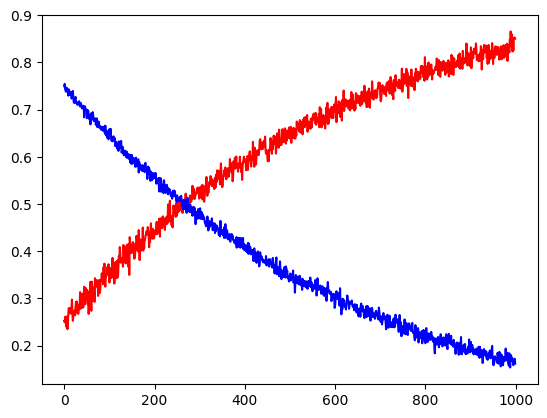

In [5]:
#plotting the QASM simulation results
time_array_QASM = np.arange(0, 1000, 1)

plt.plot(time_array_QASM, p_ground, 'r-', label="Ground state")
plt.plot(time_array_QASM, p_excited, 'b-', label='Excited state')